In [ ]:
!nvidia-smi

Thu Dec 12 17:14:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.4/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets
!pip install roboflow

from google.colab import userdata
from roboflow import Roboflow


from roboflow import Roboflow
rf = Roboflow(api_key="kzPFAj53jHO2QZTgVIZU")
project = rf.workspace("pmr-tqtxw").project("football-players-detection-3zvbc-koyzy")
version = project.version(1)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/football-players-detection-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	 val_batch0_labels.jpg
confusion_matrix_normalized.png			    R_curve.png		 val_batch0_pred.jpg
confusion_matrix.png				    results.csv		 val_batch1_labels.jpg
events.out.tfevents.1734021914.bfe88b1ac9ff.2662.0  results.png		 val_batch1_pred.jpg
F1_curve.png					    roboflow_deploy.zip  val_batch2_labels.jpg
labels_correlogram.jpg				    state_dict.pt	 val_batch2_pred.jpg
labels.jpg					    train_batch0.jpg	 weights
model_artifacts.json				    train_batch1.jpg
P_curve.png					    train_batch2.jpg


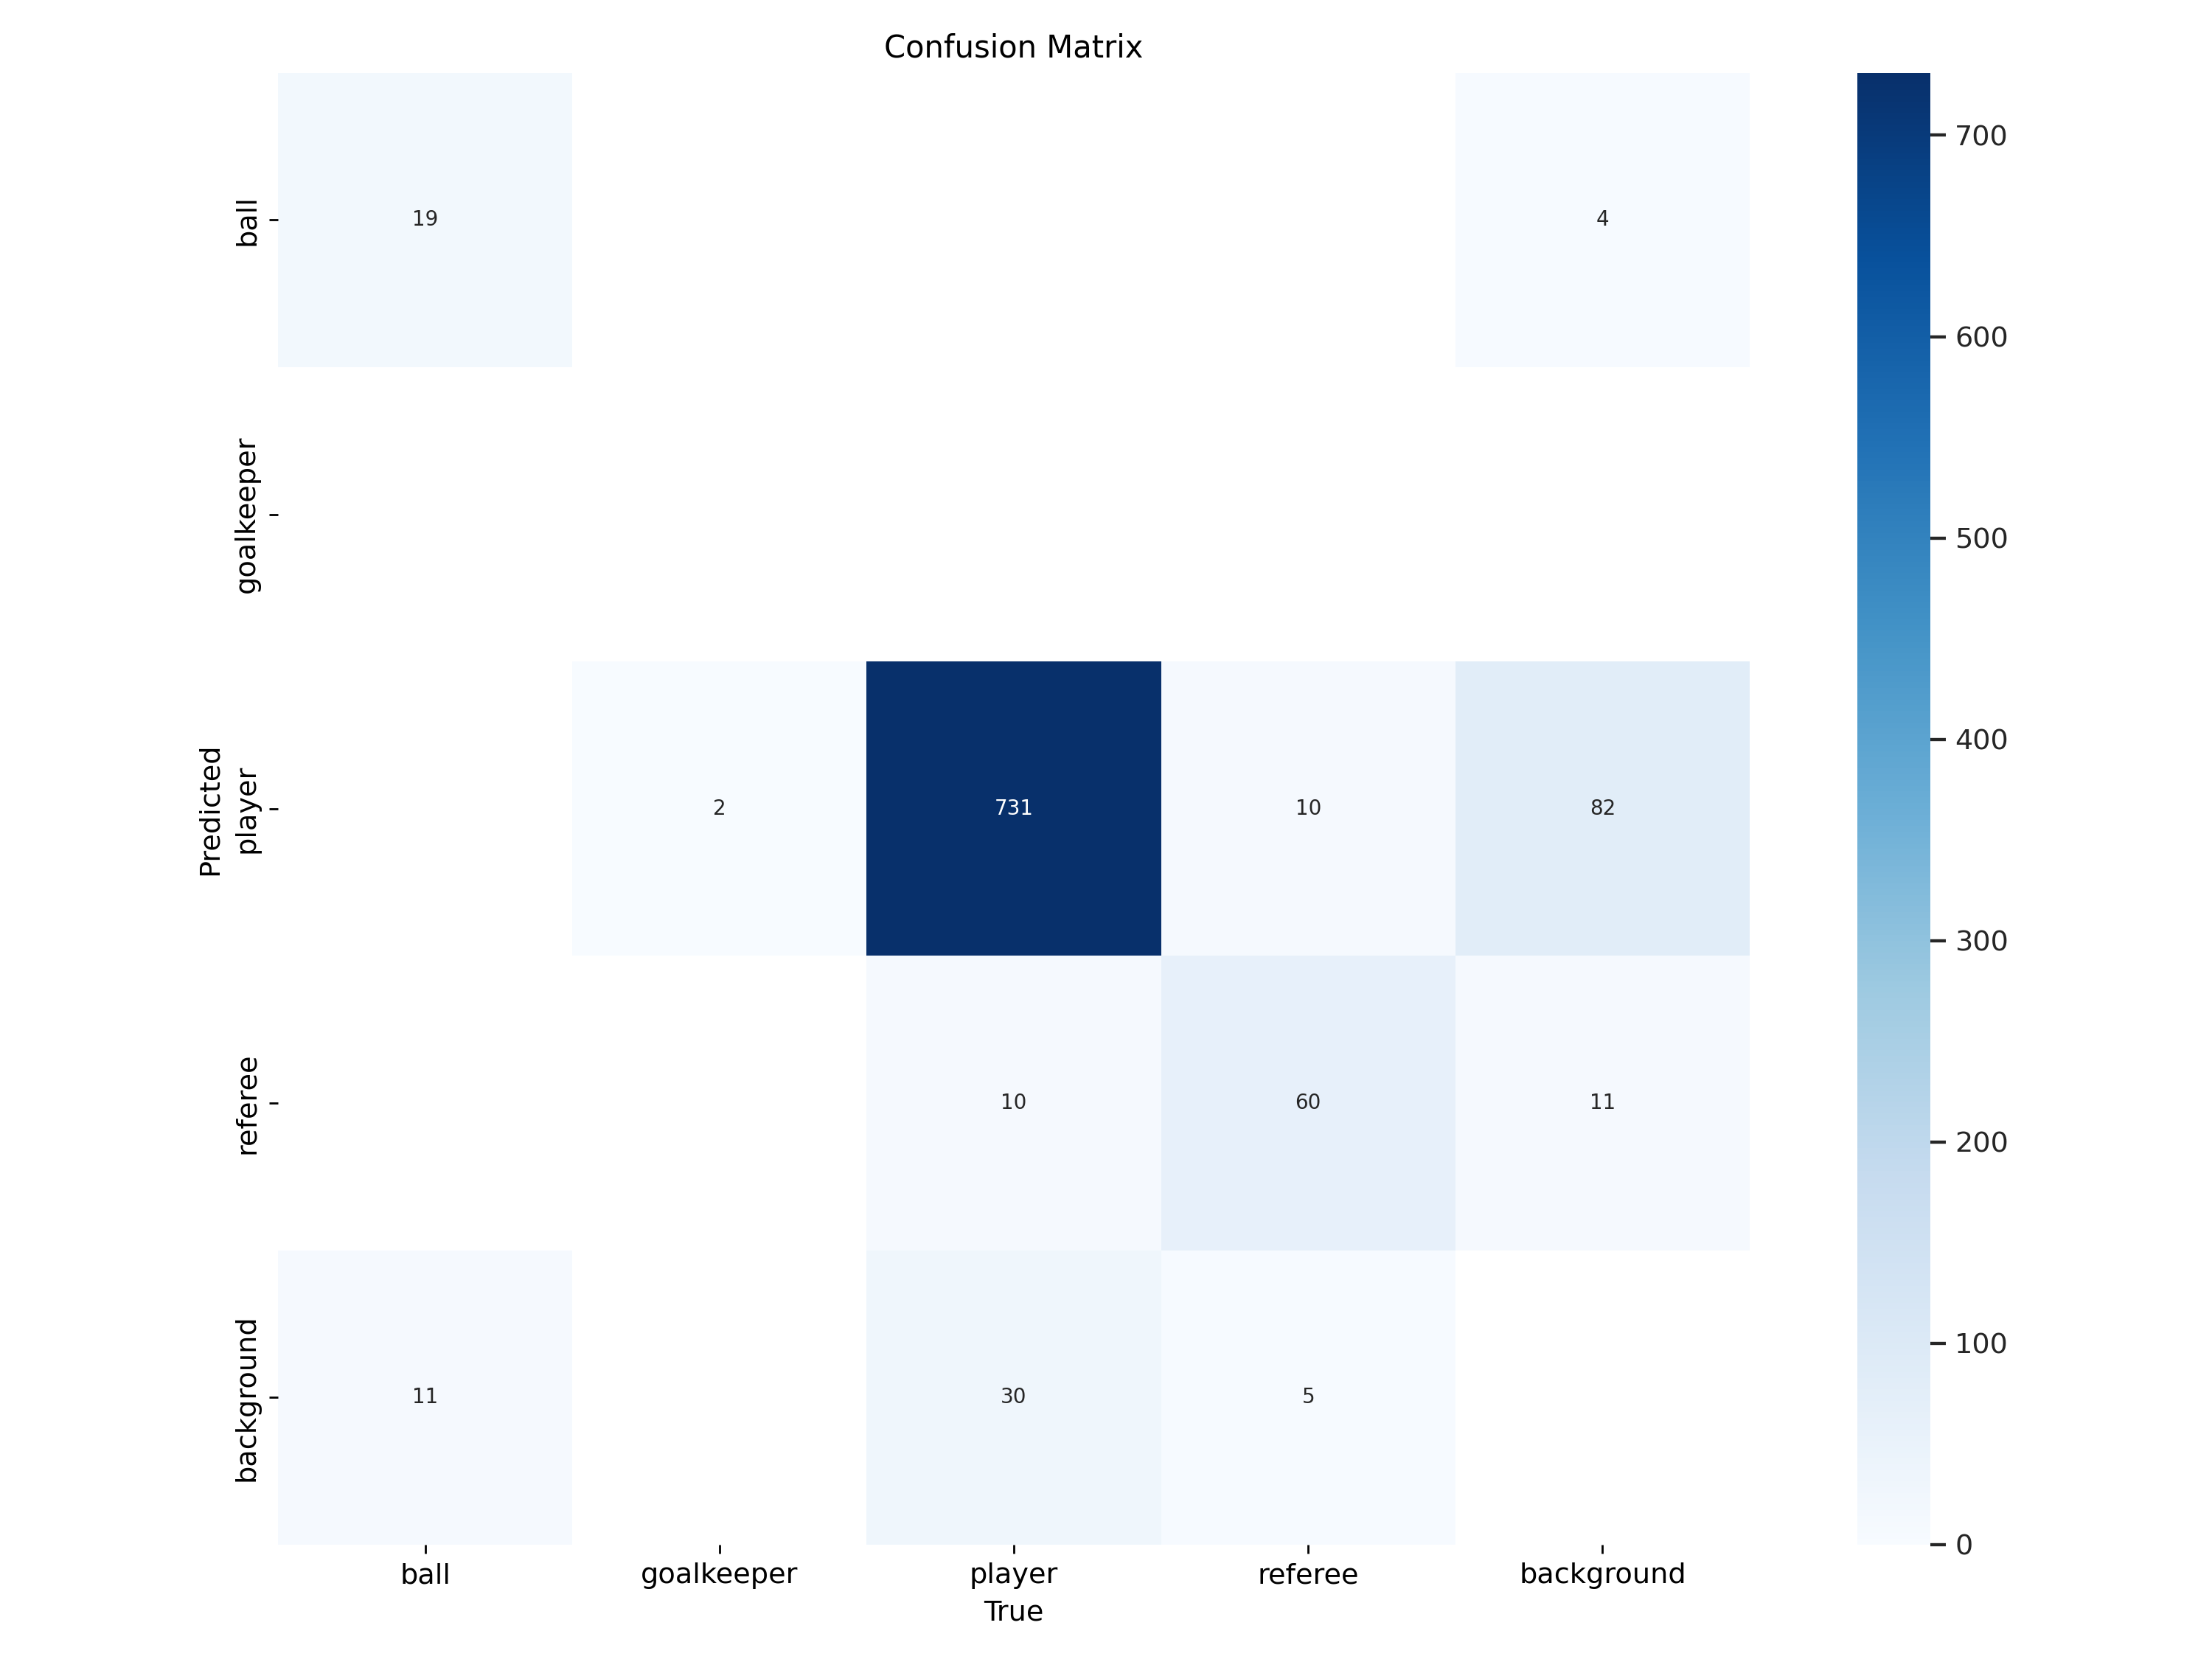

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

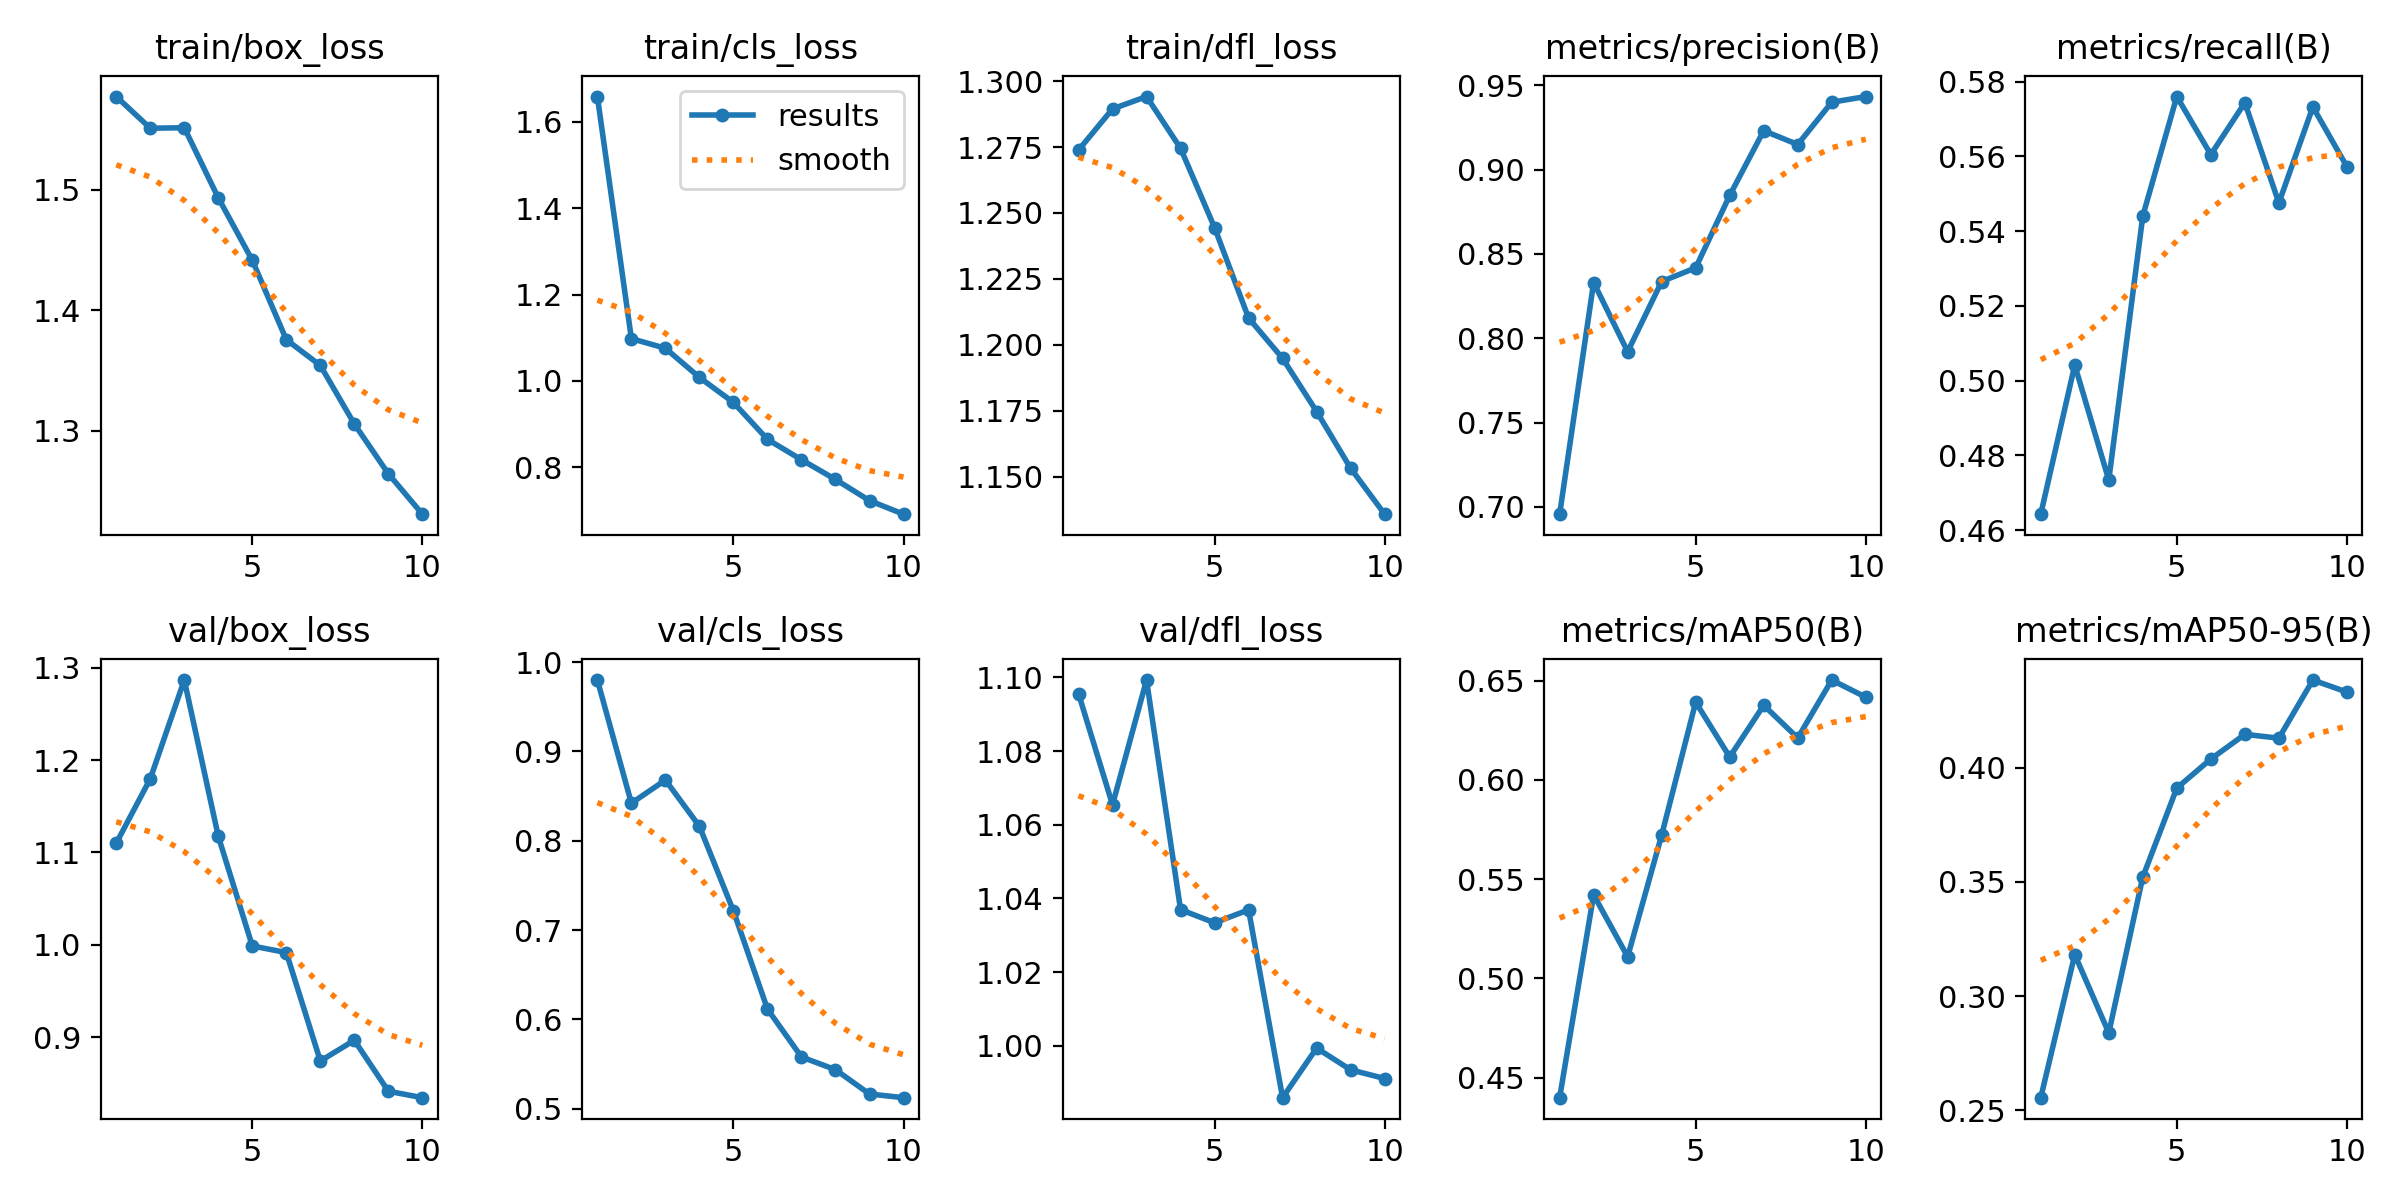

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

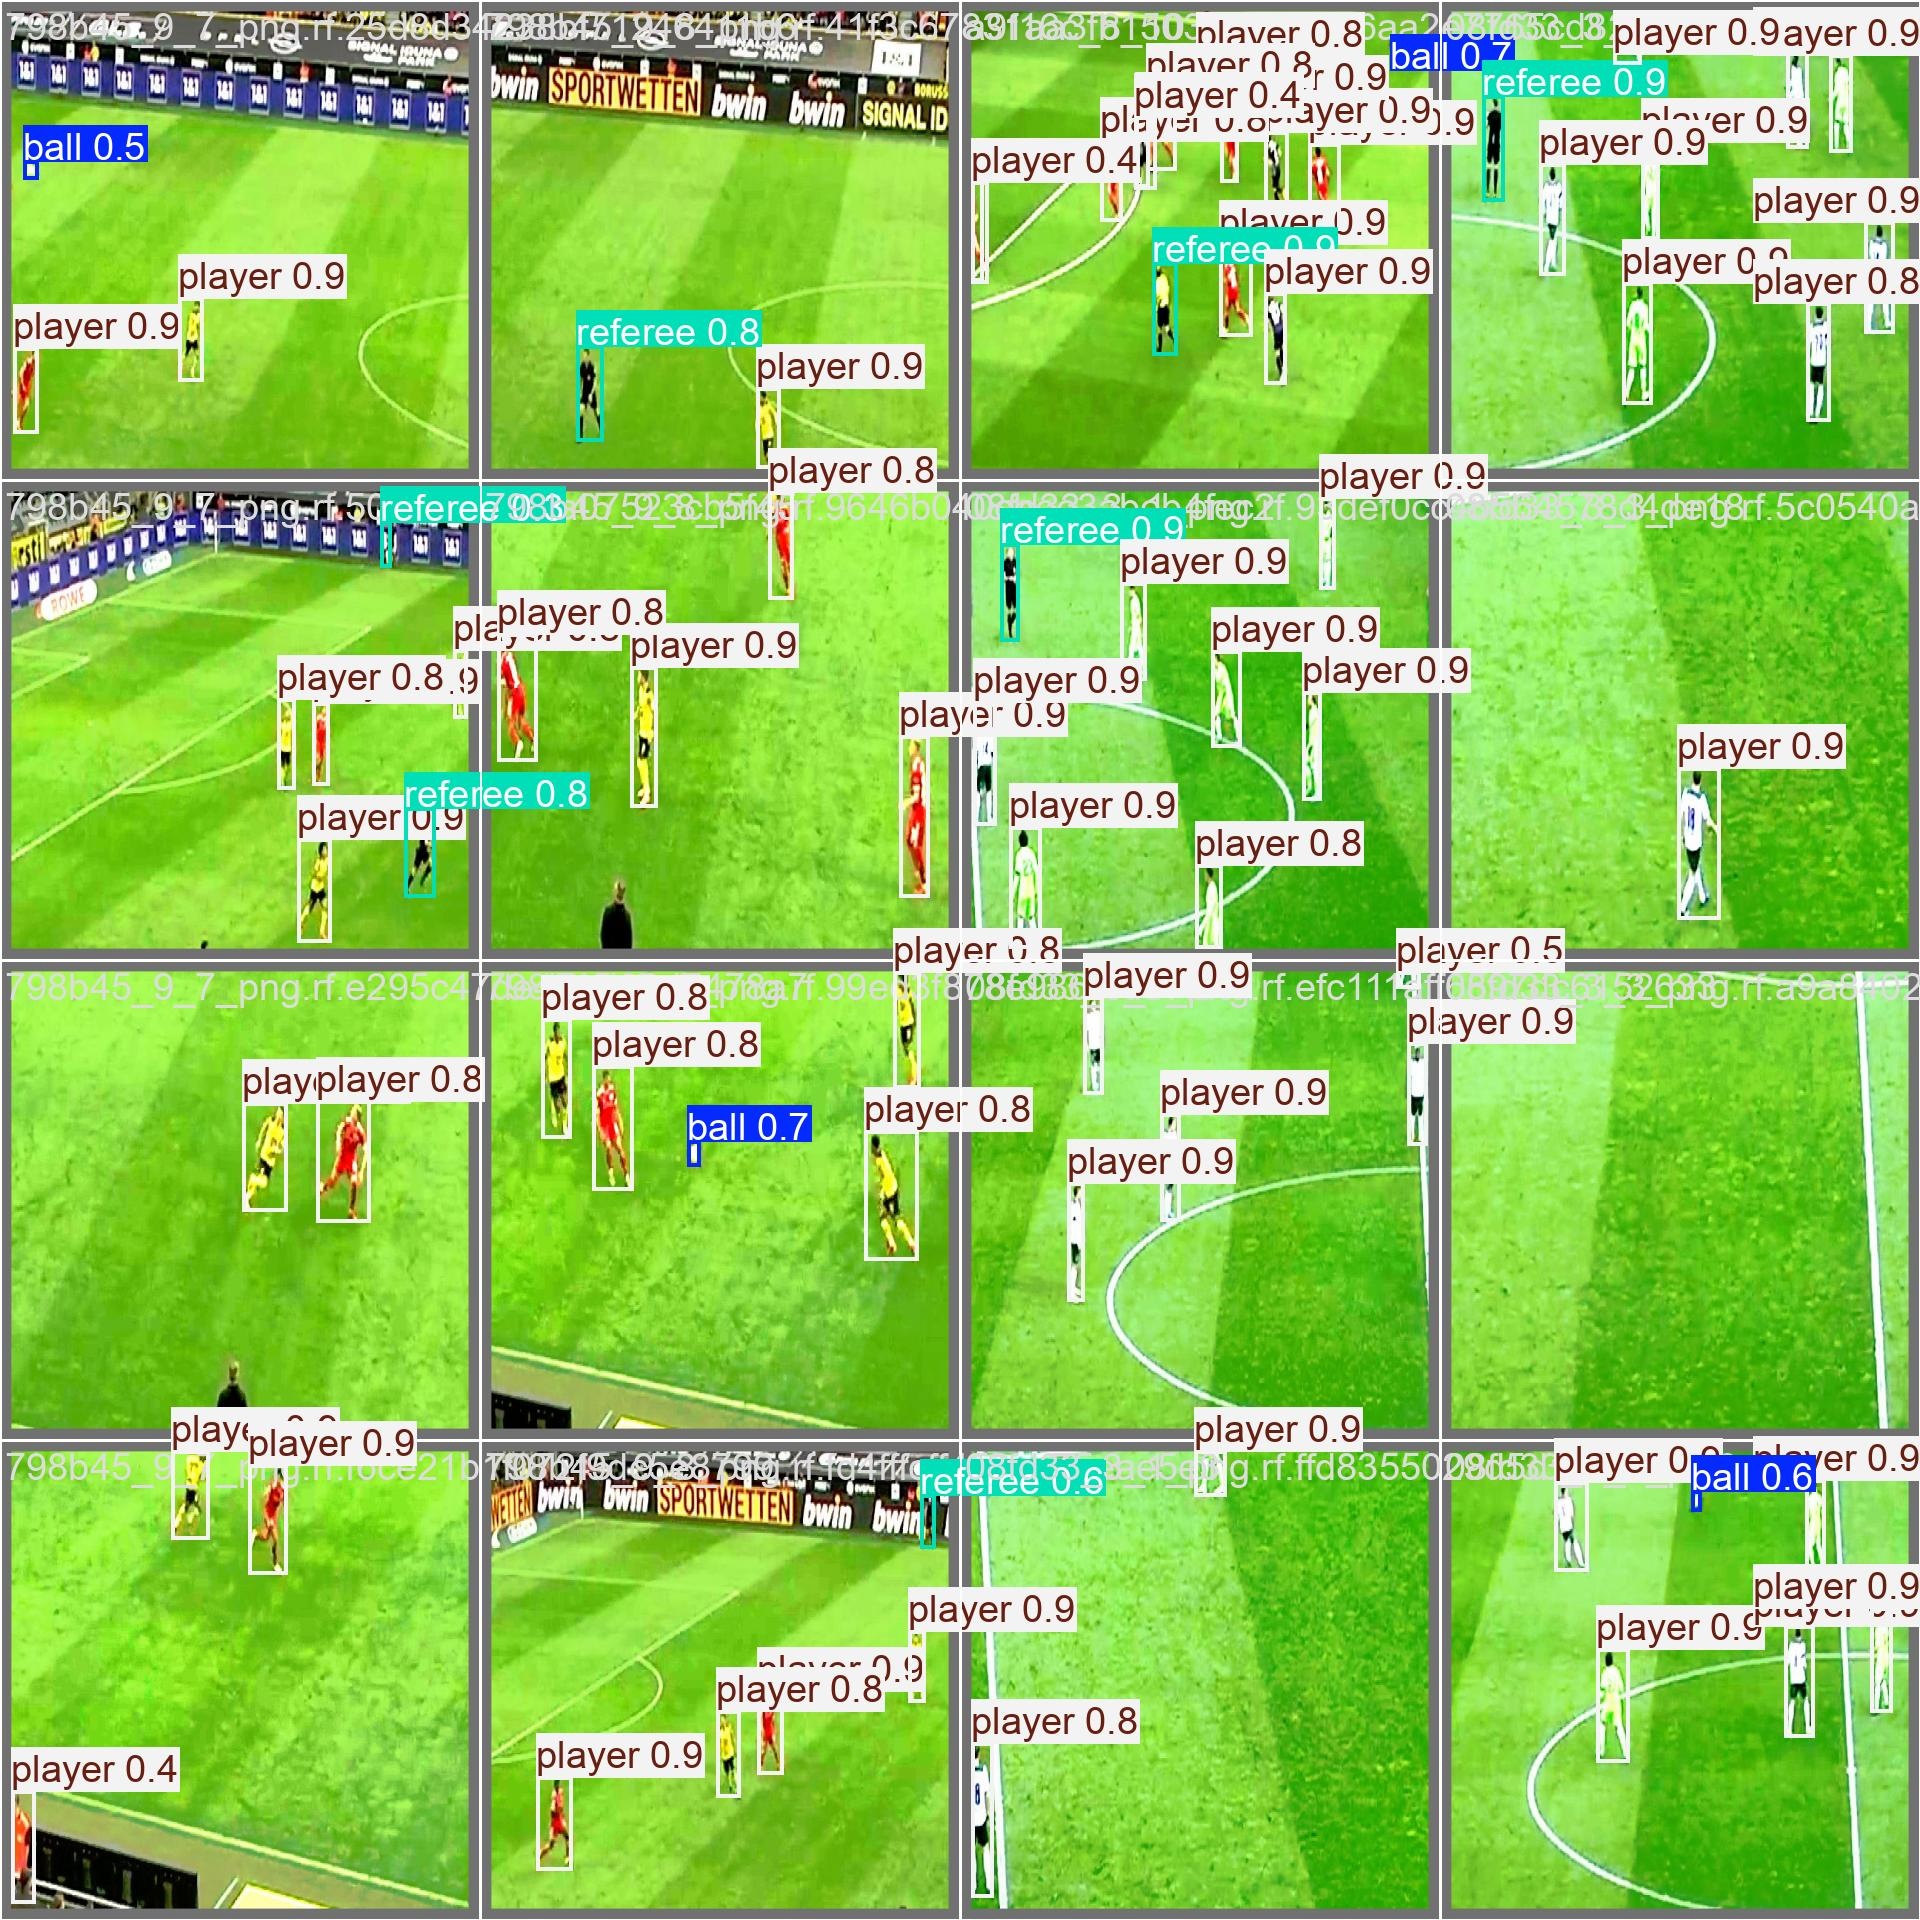

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/football-players-detection-1/valid/labels.cache... 196 images, 24 backgrounds, 0 corrupt: 100% 196/196 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 13/13 [00:05<00:00,  2.35it/s]
                   all        196        878      0.938      0.573       0.65      0.438
                  ball         30         30      0.949        0.6      0.728      0.354
            goalkeeper          2          2          1          0     0.0277     0.0225
                player        172        771      0.938       0.92      0.967      0.763
               referee         65         75      0.867      0.773       0.88      0.612
Speed: 1.3ms preprocess, 10.9ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs

image 1/100 /content/datasets/football-players-detection-1/test/images/08fd33_3_6_png.rf.178329e8ced30f358623d757704d152a.jpg: 640x640 1 player, 18.6ms
image 2/100 /content/datasets/football-players-detection-1/test/images/08fd33_3_6_png.rf.3d1ddb1ac490bb3c193dc50cd0ea688a.jpg: 640x640 8 players, 1 referee, 15.7ms
image 3/100 /content/datasets/football-players-detection-1/test/images/08fd33_3_6_png.rf.7e4b6df926ab4bf4808f807ba8782b66.jpg: 640x640 1 ball, 5 players, 15.6ms
image 4/100 /content/datasets/football-players-detection-1/test/images/08fd33_3_6_png.rf.bc733103a1a7bea0619848b3575366fc.jpg: 640x640 (no detections), 15.6ms
image 5/100 /content/datasets/football-players-detection-1/test/images/08fd33_9_3_png.rf.447bc5607383caaf066d0568d31da9fe.jpg: 640x640 1 player, 15.5ms
image 6/100 /content/datasets/football-player

**NOTE:** Let's take a look at few results.

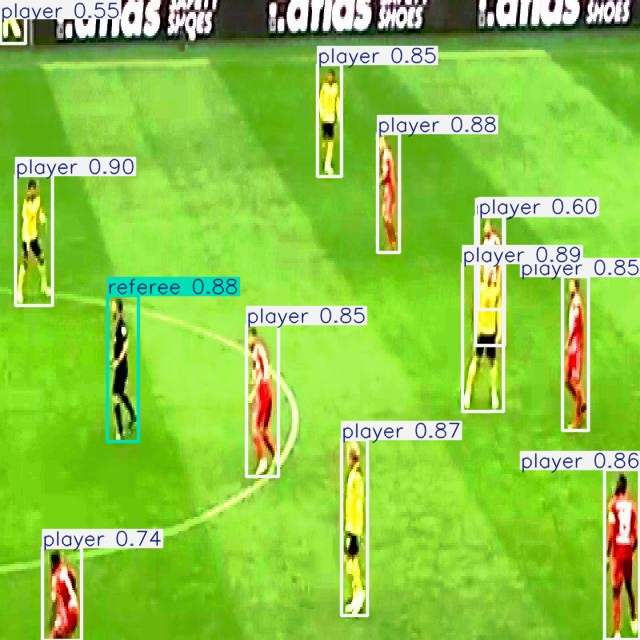

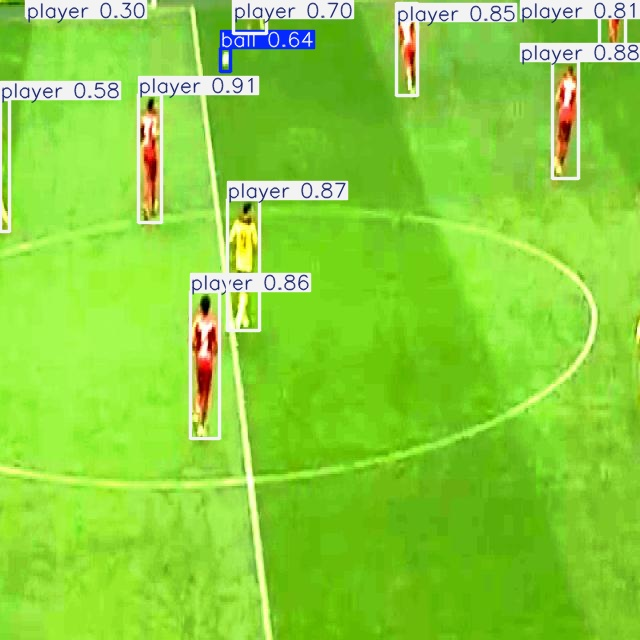

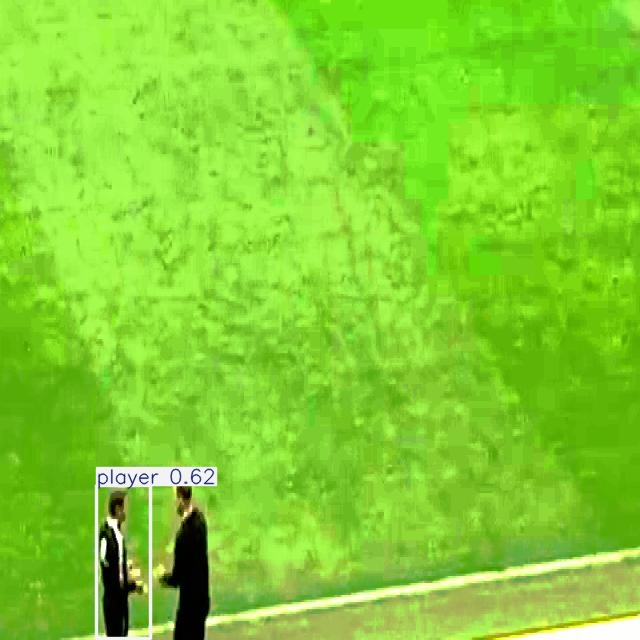

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.


In [ ]:
!pip install inference

['train', 'README.roboflow.txt', 'README.dataset.txt', 'data.yaml', 'valid', 'test']


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.